In [16]:
#!/usr/bin/env python3

from bioblend.galaxy import GalaxyInstance
import pandas as pd
import io
import sys

# === CONFIGURATION ===
GALAXY_URL = "https://usegalaxy.eu"          # your Galaxy instance
API_KEY = "cc8ab6117e2e58a8ca8ac12ce8680ed8"                # paste your API key
HISTORY_NAME = "Cloud co-assembly"           # the history name
COLLECTION_NAME = "Kraken2 on collection 29: Report"  # the collection name
OUTPUT_FILE = "kraken2_combined.csv"         # optional output

# === CONNECT TO GALAXY ===
gi = GalaxyInstance(url=GALAXY_URL, key=API_KEY)

# --- Find the history ---
histories = gi.histories.get_histories(name=HISTORY_NAME)
if not histories:
    sys.exit(f"❌ History '{HISTORY_NAME}' not found.")
history_id = histories[0]["id"]
print(f"📘 Found history: {HISTORY_NAME} (id={history_id})")

# --- Find the dataset collection ---
contents = gi.histories.show_history(history_id, contents=True)
collection = next(
    (c for c in contents if c["history_content_type"] == "dataset_collection"
     and c["name"] == COLLECTION_NAME),
    None,
)
if not collection:
    sys.exit(f"❌ Collection '{COLLECTION_NAME}' not found in history '{HISTORY_NAME}'.")

collection_id = collection["id"]
coll_details = gi.dataset_collections.show_dataset_collection(collection_id)
elements = coll_details["elements"]
print(f"📦 Found collection with {len(elements)} elements.")

# --- Download and read each element into a DataFrame ---
all_dfs = []

for element in elements:
    dataset = element["object"]
    name = element["element_identifier"]
    ds_id = dataset["id"]
    state = dataset["state"]

    if state != "ok":
        print(f"⚠️ Skipping {name} (state={state})")
        continue

    print(f"⬇️  Downloading {name} ...")
    content = gi.datasets.download_dataset(ds_id, use_default_filename=False)
    try:
        df = pd.read_csv(io.BytesIO(content), sep="\t", comment="#", engine="python")
        df["source_file"] = name
        all_dfs.append(df)
    except Exception as e:
        print(f"⚠️ Could not read {name}: {e}")

if not all_dfs:
    sys.exit("❌ No valid dataframes were loaded.")

# --- Combine all into one DataFrame ---
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"✅ Combined {len(all_dfs)} files → {len(combined_df):,} rows.")

# --- Save to disk ---
combined_df.to_csv(OUTPUT_FILE, index=False)
print(f"💾 Saved to {OUTPUT_FILE}")

# Optional: preview first rows
print("\nPreview:")
print(combined_df.head())


📘 Found history: Cloud co-assembly (id=7df774b3b4a59db4)
📦 Found collection with 14 elements.
⬇️  Downloading ERR9966616 ...
⬇️  Downloading ERR9966617 ...
⬇️  Downloading ERR9966618 ...
⬇️  Downloading ERR9966619 ...
⬇️  Downloading ERR9966620 ...
⬇️  Downloading ERR9966621 ...
⬇️  Downloading ERR9966622 ...
⬇️  Downloading ERR9966623 ...
⬇️  Downloading ERR9966624 ...
⬇️  Downloading ERR9966625 ...
⬇️  Downloading ERR9966626 ...
⬇️  Downloading ERR9966627 ...
⬇️  Downloading ERR9966628 ...
⬇️  Downloading ERR9966629 ...
✅ Combined 14 files → 664,216 rows.
💾 Saved to kraken2_combined.csv

Preview:
    89.11   20707791  20707791.1   U        0               unclassified  \
0   10.89  2529641.0       981.0   R        1                       root   
1   10.87  2526117.0     29226.0  R1   131567         cellular organisms   
2    7.26  1686142.0     89149.0   D        2                   Bacteria   
3    3.27   759103.0      5459.0  D1  1783272        Terrabacteria group   
4    2.84   65

In [17]:
abundance_dfs = []
for df in all_dfs:
    df.columns = ["percentage", "reads_clade", "reads_taxon", "rank_code", "taxid", "name", "source_file"]
    sub = df[["taxid", "percentage"]].copy()
    sample_name = str(df["source_file"].iloc[0])
    sub.rename(columns={"percentage": sample_name}, inplace=True)
    abundance_dfs.append(sub)
    # print(df.head())

merged = abundance_dfs[0]
for sub in abundance_dfs[1:]:
    merged = pd.merge(merged, sub, on=["taxid"], how="outer")

merged.fillna(0, inplace=True)
merged.set_index("taxid", inplace=True)


merged = merged.T
merged.head()

taxid,1,2,6,7,9,10,11,13,14,16,...,3098986,3099314,3100173,3100174,3100175,3100176,3103144,3104013,3108222,3108736
ERR9966616,10.89,7.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR9966617,9.57,6.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR9966618,9.74,8.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR9966619,5.57,2.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR9966620,10.00,6.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TODO: check diff if only species are taken, filter for > 0.5 abund

[[ 1.81678785  1.53662226  0.         ...  1.49357599  1.64509289
  -1.0017759 ]
 [ 1.21509897  1.26321351  0.         ...  0.05150262  1.36807025
  -0.93944228]
 [ 1.29258921  2.00597394  0.         ...  0.05150262  2.0957765
  -0.3634391 ]
 ...
 [-1.12328281 -0.90582922  0.         ...  0.7725393  -0.73276347
  -0.431252  ]
 [-1.01844308 -0.94228372  0.         ...  0.7725393  -0.82730941
  -0.23071815]
 [-0.60820066 -0.82380659  0.         ... -1.39057075 -0.85592427
  -0.03509704]]
[2 2 2 0 1 0 0 0 0 0 0 0 0 0]


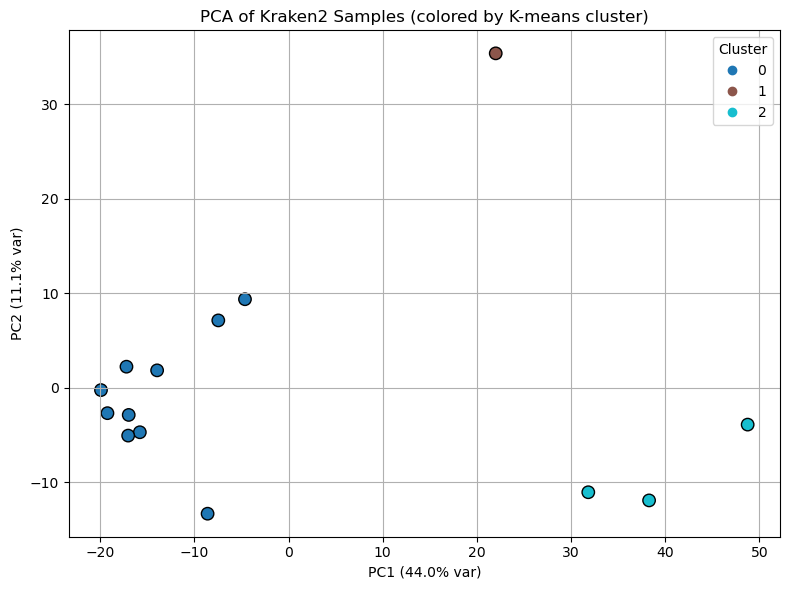

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

df = merged

# --- Scale data ---
X = merged.values
X_scaled = StandardScaler().fit_transform(X)

print(X_scaled)

# --- Perform K-means clustering ---
n_clusters = 3  # change as desired
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# db = DBSCAN(eps=0.1, min_samples=2).fit(X_scaled)
# clusters = db.labels_

print(clusters)

df["cluster"] = clusters

# --- PCA for 2D visualization ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df["PC1"] = pca_result[:, 0]
df["PC2"] = pca_result[:, 1]

# --- Plot ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["PC1"], df["PC2"], c=df["cluster"], cmap="tab10", s=80, edgecolor="k")

plt.title("PCA of Kraken2 Samples (colored by K-means cluster)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()